# Variational Inference

## 0. Initialize

In [1]:
#mathematics
using ForwardDiff
using LinearAlgebra
using SpecialFunctions

#statistics
using Random
using Statistics
using Distributions

#visualize
using Plots
pyplot()

#macros
using ProgressMeter
using UnPack

## 1. create data

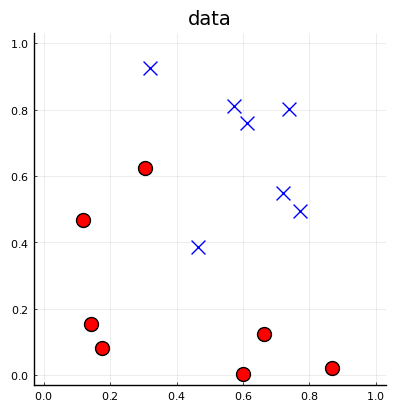

In [2]:
#plot the data and return the figure
function plot_data(X, Y)
    _,N = size(X)
    fig = plot(xticks=0:0.2:1, xlim=[0,1], yticks=0:0.2:1, ylim=[0,1], aspect_ratio=:equal, title="data", legend=false)
    for k in 1:N
        if Y[k]==1
            plot!([X[1,k]], [X[2,k]], st=:scatter, markershape=:circle, markersize=10, color="red")
        else
            plot!([X[1,k]], [X[2,k]], st=:scatter, markershape=:x, markersize=10, color="blue")
        end
    end
    return fig
end

function plot_data(fig, X, Y)
    _,N = size(X)
    fig = plot!(xticks=0:0.2:1, xlim=[0,1], yticks=0:0.2:1, ylim=[0,1], aspect_ratio=:equal, legend=false)
    for k in 1:N
        if Y[k]==1
            plot!([X[1,k]], [X[2,k]], st=:scatter, markershape=:circle, markersize=10, color="red")
        else
            plot!([X[1,k]], [X[2,k]], st=:scatter, markershape=:x, markersize=10, color="blue")
        end
    end
    return fig
end

#create the data
Random.seed!(46)
N = 14
X = hcat(rand(Beta(1.1,3), 2, div(N,2)), rand(Beta(1.9,1.1), 2, div(N,2)))
Y = vcat(ones(div(N,2)), zeros(div(N,2)))
data = (X=X,Y=Y,N=N)

#size
Random.seed!(42)
Dx,N = size(X)
Dy = 1
D₀ = 5
st = (Dx=Dx, Dy=Dy, D₀=D₀)

#plot the data
fig1 = plot_data(X, Y)
savefig(fig1, "figs-RT/fig1.png")

## 2. variational inference - reparameterization trick

In [3]:
#plot the data and return the figure
function plot_data(X, Y)
    _,N = size(X)
    fig = plot(xticks=0:0.2:1, xlim=[0,1], yticks=0:0.2:1, ylim=[0,1], aspect_ratio=:equal, title="data", legend=false)
    for k in 1:N
        if Y[k]==1
            plot!([X[1,k]], [X[2,k]], st=:scatter, markershape=:circle, markersize=10, color="red")
        else
            plot!([X[1,k]], [X[2,k]], st=:scatter, markershape=:x, markersize=10, color="blue")
        end
    end
    return fig
end

function plot_data(fig, X, Y)
    _,N = size(X)
    fig = plot!(xticks=0:0.2:1, xlim=[0,1], yticks=0:0.2:1, ylim=[0,1], aspect_ratio=:equal, legend=false)
    for k in 1:N
        if Y[k]==1
            plot!([X[1,k]], [X[2,k]], st=:scatter, markershape=:circle, markersize=10, color="red")
        else
            plot!([X[1,k]], [X[2,k]], st=:scatter, markershape=:x, markersize=10, color="blue")
        end
    end
    return fig
end

#initialize the parameter
function init_params(st)
    @unpack  Dx, Dy, D₀ = st
    W₂ = rand(D₀, Dx)
    W₃ = rand(Dy, D₀)
    b₂ = zeros(D₀)
    b₃ = zeros(Dy)
    return W₂, W₃, b₂, b₃
end

#stick the weights and biases to a large matrix
function stick_params(W₂, W₃, b₂, b₃, Dx)
    tmp1 = vcat(b₂', W₂')
    tmp2 = hcat(tmp1, zeros(Dx+1))
    tmp3 = hcat(W₃, b₃)
    return vcat(tmp2, tmp3)
end

#devide the paramters vector to weights and biases
function reshape_params(wvec, st)
    @unpack  Dx, Dy, D₀ = st
    W = reshape(wvec, (Dx+Dy+1, D₀+1))
    W₂ = view(W, 2:Dx+1, 1:D₀)'
    W₃ = view(W, Dx+2:Dx+Dy+1, 1:D₀)
    b₂ = view(W, 1, 1:D₀)
    b₃ = view(W, Dx+2:Dx+Dy+1, D₀+1)
    return W₂, W₃, b₂, b₃
end 

#sigmoid function
σ(ξ) = 1/(1+exp(-ξ)) 

#Neural Network
function nn(x, wvec, st)
    W₂, W₃, b₂, b₃ = reshape_params(wvec, st)
    return σ.(W₃*σ.(W₂*x+b₂) + b₃)
end

#log pdf of prior, model, posterior
logpprior(wvec, λw, dw) = logpdf(MvNormal(zeros(dw),1/sqrt(λw)), wvec)
logpmodel(y, x, wvec, st) = logpdf(Bernoulli(nn(x,wvec,st)[1]), y)
loglik(X, Y, N, wvec, st) = sum([logpmodel(Y[n], X[:,n], wvec, st) for n in 1:N])

function logppost(wvec, data, model_params)
    @unpack X,Y,N = data
    @unpack λw,dw,st = model_params
    return loglik(X, Y, N, wvec, st) + logpprior(wvec, λw, dw)
end

function logppost(wvec, λw, data, model_params)
    @unpack X,Y,N = data
    @unpack dw,st = model_params
    return loglik(X, Y, N, wvec, st) + logpprior(wvec, λw, dw)
end

#predictive: returns the probability to new data classified to class 1
function ppred(x, wsamps, st)
    _, n_samps = size(wsamps)
    preds = zeros(n_samps)
    for j in 1:n_samps
        preds[j] = exp(logpmodel(1, x, wsamps[:,j], st))
    end
    return mean(preds)
end

#reparameterization
g(θvec, ϵvec) = θvec[1:dw] + exp.(θvec[dw+1:end]) .* ϵvec
∇θlogpmodel(y,x,θvec,ϵvec,st) = ForwardDiff.gradient(θvec->logpmodel(y, x, g(θvec, ϵvec), st), θvec)

#∇θLn(θ)
function ∇θLn(x, y, N, ϵsamps, θvec, λw, st)
    dw,S = size(ϵsamps)
    ∇θLnvecs = zeros(2*dw, S)
    for s in 1:S
        ∇θLnvecs[:,s] = ∇θlogpmodel(y,x,θvec,ϵsamps[:,s],st)
    end
    ∇θLnvec = N * mean(∇θLnvecs, dims=2)
    for j in 1:dw
        ∇θLnvec[j] += -λw*θvec[j]
        ∇θLnvec[dw+j] += 1-λw*exp(2*θvec[dw+j])
    end
    return ∇θLnvec
end

#calculate ELBO
function ELBO(X, Y, N, wsamps, θvec, λw, st)
    dw,S = size(wsamps)
    logpmodels = zeros(S)
    for s in 1:S
        for n in 1:N
            logpmodels[s] += logpmodel(Y[n], X[:,n], wsamps[:,s], st)
        end
    end
    return mean(logpmodels)-λw*sum(θvec[1:dw].^2)/2-λw*sum(exp.(2*θvec[dw+1:end]))/2+sum(θvec[dw+1:end])+dw/2+dw*log(λw)/2
end

#variational inference
function myVI(data, model_params, α, n_train, tol)
    @unpack X,Y,N = data
    @unpack λw, dw, st = model_params
    θvec = vcat(zeros(dw), ones(dw))
    n_samps = 100
    wsamps = zeros(dw, n_samps)
    history = zeros(n_train)
    history[1] = ELBO(X, Y, N, wsamps, θvec, λw, st)
    @showprogress for k in 2:n_train
        idx = rand(1:N)
        x = X[:,idx]
        y = Y[idx]
        ϵsamps = rand(MvNormal(zeros(dw), ones(dw)), n_samps)
        θvec = θvec + α*∇θLn(x, y, N, ϵsamps, θvec, λw, st)/k
        history[k] = ELBO(X, Y, N, wsamps, θvec, λw, st)
        if abs(history[k]-history[k-1])<tol
            return θvec, history[2:k]
        end
    end
    return θvec, history
end

myVI (generic function with 1 method)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


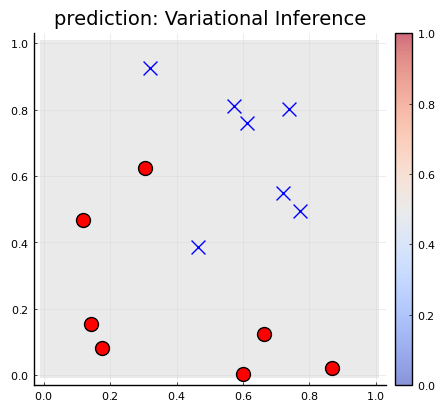

In [4]:
#initialize NN
W₂, W₃, b₂, b₃ = init_params(st)
Ws = stick_params(W₂, W₃, b₂, b₃, st.Dx)
wvec₀ = Ws[:]
dw = length(wvec₀)

#model params
λw = 1e-0
model_params = (λw=λw, dw=dw, st=st)

#calculate the variational parameters
α = 0.5
tol = 1e-6
n_train = 1000
θvec, history = myVI(data, model_params, α, n_train, tol)

#posterior sample
n_samps = 5000
wsamps = rand(MvNormal(θvec[1:dw], exp.(θvec[dw+1:end])), n_samps)

#calculate and visualize predictive
fig2 = plot(0:0.02:1, 0:0.02:1, (x1,x2)->ppred([x1,x2], wsamps, st), st=:heatmap, c=cgrad(:coolwarm), alpha=0.6, clim=(0,1))
fig42 = plot_data(fig2, X, Y)
plot!(title="prediction: Variational Inference")
savefig(fig2, "figs-RT/fig2.png")

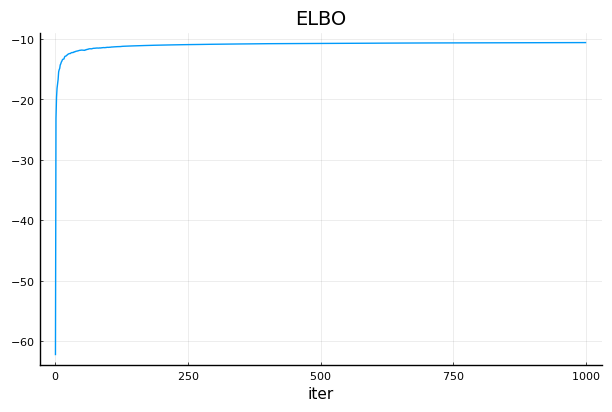

In [5]:
fig3 = plot(history, xlabel="iter", title="ELBO", label=false)
savefig(fig3, "figs-RT/fig3.png")